# Setup

In [1]:
from google.colab import drive
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import numpy as np

In [2]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/relevance/processed_data_with_stimuli.csv')
df
# df = pd.read_json(f'/content/drive/MyDrive/relevance/processed.jsonl', orient="records", lines=True)
# df_stim = pd.read_csv('/content/drive/MyDrive/relevance/relevance_stimuli.csv')

Mounted at /content/drive


,submission_id,StimID,AnswerCertainty,AnswerPolarity,ContextType,pos,pri,rel,bch,ech,...,beta_bch_mean,beta_bch_rank_mean,beta_bch_rank_diff_mean,Answer,Context,CriticalProposition,YourQuestion,YourQuestionIntro,AnswerIntro,stimulus
0,5794,2,non_answer,positive,neutral,0.70,0.70,0.04,0.00,0.00,...,38.36,1016.38,376.96,We're having chicken soup for lunch.,"After a long day of school, you come home star...",we're having hamburgers,Are we having hamburgers for dinner?,You ask your sibling:,Your sibling responds:,GroupID: **2non_answerpositiveneutral**\n\nAns...
1,5839,2,non_answer,positive,neutral,0.50,0.70,0.03,0.20,0.12,...,38.36,1016.38,376.96,We're having chicken soup for lunch.,"After a long day of school, you come home star...",we're having hamburgers,Are we having hamburgers for dinner?,You ask your sibling:,Your sibling responds:,GroupID: **2non_answerpositiveneutral**\n\nAns...
2,5857,2,non_answer,positive,neutral,0.70,0.70,0.00,0.00,0.00,...,38.36,1016.38,376.96,We're having chicken soup for lunch.,"After a long day of school, you come home star...",we're having hamburgers,Are we having hamburgers for dinner?,You ask your sibling:,Your sibling responds:,GroupID: **2non_answerpositiveneutral**\n\nAns...
3,5866,2,non_answer,positive,neutral,0.75,0.75,0.00,0.00,0.00,...,38.36,1016.38,376.96,We're having chicken soup for lunch.,"After a long day of school, you come home star...",we're having hamburgers,Are we having hamburgers for dinner?,You ask your sibling:,Your sibling responds:,GroupID: **2non_answerpositiveneutral**\n\nAns...
4,5906,2,non_answer,positive,neutral,0.55,0.55,0.00,0.00,0.00,...,38.36,1016.38,376.96,We're having chicken soup for lunch.,"After a long day of school, you come home star...",we're having hamburgers,Are we having hamburgers for dinner?,You ask your sibling:,Your sibling responds:,GroupID: **2non_answerpositiveneutral**\n\nAns...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,5927,6,exhaustive,negative,negative,0.00,0.05,1.00,0.05,0.29,...,129.39,1779.88,-354.12,The cake is finished.,It's afternoon at the office and you're ready ...,there is some cake left,Is there any cake left?,You ask your coworker Meaghan:,Meaghan responds:,GroupID: **6exhaustivenegativenegative**\n\nAn...
2336,5932,6,exhaustive,negative,negative,0.00,0.09,1.00,0.09,0.44,...,129.39,1779.88,-354.12,The cake is finished.,It's afternoon at the office and you're ready ...,there is some cake left,Is there any cake left?,You ask your coworker Meaghan:,Meaghan responds:,GroupID: **6exhaustivenegativenegative**\n\nAn...
2337,6013,6,exhaustive,negative,negative,0.02,0.08,1.00,0.06,0.26,...,129.39,1779.88,-354.12,The cake is finished.,It's afternoon at the office and you're ready ...,there is some cake left,Is there any cake left?,You ask your coworker Meaghan:,Meaghan responds:,GroupID: **6exhaustivenegativenegative**\n\nAn...
2338,6037,6,exhaustive,negative,negative,0.00,0.10,1.00,0.10,0.47,...,129.39,1779.88,-354.12,The cake is finished.,It's afternoon at the office and you're ready ...,there is some cake left,Is there any cake left?,You ask your coworker Meaghan:,Meaghan responds:,GroupID: **6exhaustivenegativenegative**\n\nAn...


In [ ]:
df.columns

Index(['submission_id', 'StimID', 'AnswerCertainty', 'AnswerPolarity',
       'ContextType', 'pos', 'pri', 'rel', 'bch', 'ech', 'klu', 'bfu',
       'conf_pos', 'conf_pri', '2ord_bch', 'beta_ech', 'beta_klu', 'beta_bfu',
       'beta_bch', 'RowID', 'GroupID', 'pos_rank', 'pri_rank', 'rel_rank',
       'bch_rank', 'ech_rank', 'klu_rank', 'bfu_rank', 'conf_pos_rank',
       'conf_pri_rank', '2ord_bch_rank', 'beta_ech_rank', 'beta_klu_rank',
       'beta_bfu_rank', 'beta_bch_rank', 'pos_rank_diff', 'pri_rank_diff',
       'rel_rank_diff', 'bch_rank_diff', 'ech_rank_diff', 'klu_rank_diff',
       'bfu_rank_diff', 'conf_pos_rank_diff', 'conf_pri_rank_diff',
       '2ord_bch_rank_diff', 'beta_ech_rank_diff', 'beta_klu_rank_diff',
       'beta_bfu_rank_diff', 'beta_bch_rank_diff', 'pos_mean', 'pos_rank_mean',
       'pos_rank_diff_mean', 'pri_mean', 'pri_rank_mean', 'pri_rank_diff_mean',
       'rel_mean', 'rel_rank_mean', 'rel_rank_diff_mean', 'bch_mean',
       'bch_rank_mean', 'bch_rank_di

In [3]:
cols = [

    # Trial Metadata
    # 'submission_id',
    # 'StimID',
    'RowID',
    'AnswerCertainty',
    # 'AnswerPolarity',
    'ContextType',
    'Answer',
    'Context',
    'YourQuestionIntro',
    'YourQuestion',

    # Raw Judgments
    'pri',
    'pos',
    'conf_pri',
    'conf_pos',
    'rel',

    # First Order Measures
    # 'bch',
    # 'ech',
    # 'klu',
    # 'bfu',

    # Second Order Measures
    # '2ord_bch',
    # 'beta_ech',
    # 'beta_klu',
    # 'beta_bfu',
    # 'beta_bch',

    # Ranks / Rank diffs
    'rel_rank',

    # 'bch_rank_diff',
    # 'ech_rank_diff',
    # 'klu_rank_diff',
    'bfu_rank_diff',

    # '2ord_bch_rank_diff',
    # 'beta_ech_rank_diff',
    # 'beta_klu_rank_diff',
    'beta_bfu_rank_diff',
    # 'beta_bch_rank_diff',

]

# General analysis

Let's find examples where there is high relevance but low belief change

In [ ]:
df[df.apply(lambda x: x.bch < 0.5 and x["2ord_bch"] < 4 and x.rel > 0.8 and x.AnswerCertainty == "exhaustive", axis=1)][cols]

Let's find even more extreme examples

In [ ]:
df[df.apply(lambda x: x.bch < 0.2 and x["2ord_bch"] < 3 and x.rel > 0.8, axis=1)][cols]

Let's find the school bus example

In [ ]:
df[df.apply(lambda x: x.YourQuestion == "Is school canceled?", axis=1)][cols]

Here are examples with low belief change but high relevance for non-answers:

In [ ]:
edf[df.apply(lambda x: x.bch < 0.1 and x["2ord_bch"] < 2 and x.rel > 0.3 and x.AnswerCertainty == "non_answer", axis=1)][cols]

,RowID,AnswerCertainty,ContextType,Answer,Context,YourQuestionIntro,YourQuestion,pri,pos,conf_pri,conf_pos,rel,rel_rank,bfu_rank_diff,beta_bfu_rank_diff
160,7non_answerpositiveneutral5803,non_answer,neutral,Lauren had sushi for lunch.,You and your colleague Lauren are CIA analysts...,You ask your colleague Alan privately:,Is Lauren the mole?,0.58,0.64,6,5,0.51,559.5,-109.0,697.5
215,1non_answerpositivepositive5936,non_answer,positive,There are supposed to be 100 guests.,It's the day of Kim and Sam's wedding. The wed...,You ask your friend Clara:,Will they have the ceremony outdoors?,0.90,0.97,7,6,0.80,1269.0,-196.5,590.0
216,1non_answerpositivepositive5944,non_answer,positive,There are supposed to be 100 guests.,It's the day of Kim and Sam's wedding. The wed...,You ask your friend Clara:,Will they have the ceremony outdoors?,0.60,0.64,5,5,0.40,471.0,-80.5,-39.5
217,1non_answerpositivepositive5973,non_answer,positive,There are supposed to be 100 guests.,It's the day of Kim and Sam's wedding. The wed...,You ask your friend Clara:,Will they have the ceremony outdoors?,0.81,0.80,6,6,0.45,501.5,-165.0,1.0
218,1non_answerpositivepositive5987,non_answer,positive,There are supposed to be 100 guests.,It's the day of Kim and Sam's wedding. The wed...,You ask your friend Clara:,Will they have the ceremony outdoors?,0.50,0.51,6,5,0.31,413.0,-98.5,844.0
221,1non_answerpositivepositive6030,non_answer,positive,There are supposed to be 100 guests.,It's the day of Kim and Sam's wedding. The wed...,You ask your friend Clara:,Will they have the ceremony outdoors?,1.00,1.00,6,7,0.66,874.0,-731.0,985.0
684,11non_answerpositivenegative6002,non_answer,negative,She's bringing a bottle of wine.,You’re throwing a party and you’re expecting y...,You text your friend Joe to ask:,Is Jane going to be late?,0.22,0.24,3,3,0.44,493.0,-129.0,-267.0
886,6non_answerpositivepositive5864,non_answer,positive,"The cake was half chocolate, half vanilla.",It's afternoon at the office and you're ready ...,You ask your coworker Meaghan:,Is there any cake left?,0.65,0.65,5,5,0.45,501.5,-358.5,-394.5
1038,1non_answerpositiveneutral5948,non_answer,neutral,There are supposed to be 100 guests.,It's the day of Kim and Sam's wedding. The wed...,You ask your friend Clara:,Will they have the ceremony outdoors?,0.77,0.80,6,6,0.40,471.0,-75.0,103.5
1039,1non_answerpositiveneutral5968,non_answer,neutral,There are supposed to be 100 guests.,It's the day of Kim and Sam's wedding. The wed...,You ask your friend Clara:,Will they have the ceremony outdoors?,0.50,0.45,6,6,0.33,423.0,-16.0,517.0


# Does Prior Matter?

In [6]:
cols = [

    # Trial Metadata
    # 'submission_id',
    'StimID',
    # 'RowID',
    'AnswerCertainty',
    'AnswerPolarity',
    'ContextType',
    'Answer',
    'Context',
    'YourQuestionIntro',
    'YourQuestion',

    # Raw Judgments
    'pri',
    'pos',
    'conf_pri',
    'conf_pos',
    'rel',

    # First Order Measures
    'bch',
    # 'ech',
    # 'klu',
    # 'bfu',

    # Second Order Measures
    # '2ord_bch',
    # 'beta_ech',
    # 'beta_klu',
    # 'beta_bfu',
    # 'beta_bch',

    # Ranks / Rank diffs
    # 'rel_rank',

    # 'bch_rank_diff',
    # 'ech_rank_diff',
    # 'klu_rank_diff',
    # 'bfu_rank_diff',

    # '2ord_b ch_rank_diff',
    # 'beta_ech_rank_diff',
    # 'beta_klu_rank_diff',
    # 'beta_bfu_rank_diff',
    # 'beta_bch_rank_diff',

]

In [7]:
df_ = df[cols]
df_ = df_[df_.apply(lambda x:
                    x.AnswerCertainty != "non_answer"
                    # and x.ContextType != "neutral"
                    , axis=1)]
df_["expected_belief_change"] = df_.apply(lambda x:
                                          "low" if x.AnswerPolarity == x.ContextType
                                          else "mid" if x.ContextType == "neutral"
                                          else "high"
                                          , axis=1)
df_["AnswerCondition"] = df_.apply(lambda x: x.AnswerCertainty + "-" + x.AnswerPolarity, axis=1)
# df_.set_index(["StimID", "AnswerCertainty", "expected_belief_change"])
df_

<ipython-input-7-2df2730ad73a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_["expected_belief_change"] = df_.apply(lambda x:
<ipython-input-7-2df2730ad73a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_["AnswerCondition"] = df_.apply(lambda x: x.AnswerCertainty + "-" + x.AnswerPolarity, axis=1)


,StimID,AnswerCertainty,AnswerPolarity,ContextType,Answer,Context,YourQuestionIntro,YourQuestion,pri,pos,conf_pri,conf_pos,rel,bch,expected_belief_change,AnswerCondition
12,3,low_certainty,positive,negative,He lives in the suburbs.,"Joe is the new guy at work, and he's pretty cu...",You ask your coworker Laura:,Is Joe married?,0.25,0.50,3,2,0.11,0.25,high,low_certainty-positive
13,3,low_certainty,positive,negative,He lives in the suburbs.,"Joe is the new guy at work, and he's pretty cu...",You ask your coworker Laura:,Is Joe married?,0.35,0.47,4,4,0.63,0.12,high,low_certainty-positive
14,3,low_certainty,positive,negative,He lives in the suburbs.,"Joe is the new guy at work, and he's pretty cu...",You ask your coworker Laura:,Is Joe married?,0.60,0.60,5,6,0.60,0.00,high,low_certainty-positive
15,3,low_certainty,positive,negative,He lives in the suburbs.,"Joe is the new guy at work, and he's pretty cu...",You ask your coworker Laura:,Is Joe married?,0.50,0.50,7,7,0.00,0.00,high,low_certainty-positive
16,3,low_certainty,positive,negative,He lives in the suburbs.,"Joe is the new guy at work, and he's pretty cu...",You ask your coworker Laura:,Is Joe married?,0.21,0.40,5,4,0.60,0.19,high,low_certainty-positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,6,exhaustive,negative,negative,The cake is finished.,It's afternoon at the office and you're ready ...,You ask your coworker Meaghan:,Is there any cake left?,0.05,0.00,3,7,1.00,0.05,low,exhaustive-negative
2336,6,exhaustive,negative,negative,The cake is finished.,It's afternoon at the office and you're ready ...,You ask your coworker Meaghan:,Is there any cake left?,0.09,0.00,4,7,1.00,0.09,low,exhaustive-negative
2337,6,exhaustive,negative,negative,The cake is finished.,It's afternoon at the office and you're ready ...,You ask your coworker Meaghan:,Is there any cake left?,0.08,0.02,6,6,1.00,0.06,low,exhaustive-negative
2338,6,exhaustive,negative,negative,The cake is finished.,It's afternoon at the office and you're ready ...,You ask your coworker Meaghan:,Is there any cake left?,0.10,0.00,6,7,1.00,0.10,low,exhaustive-negative


This is how the low- mid- and high-expected belief change relevance scores vary for ALL answers in the dataset.

In [ ]:
sns.catplot(data=df_, col="AnswerCondition", row="StimID",
            y="rel", hue="expected_belief_change", kind="violin", hue_order=["low", "mid", "high"])

Output hidden; open in https://colab.research.google.com to view.

Now we take the mean for each `AnswerCondition/StimID pair` and compute the difference for `high` and `low` values of `expected_belief_change`.

In [14]:
df_diff = df_[["StimID", "expected_belief_change", "AnswerCondition", "AnswerCertainty", "rel", "bch"]]
df_diff = df_diff.groupby(["StimID", "AnswerCondition", "AnswerCertainty", "expected_belief_change"]).mean().unstack()

df_diff["rel_difference"] = df_diff.apply(lambda x:
                                      x[("rel", "high")] - x[("rel", "low")]
                                      , axis=1)
df_diff["bch_difference"] = df_diff.apply(lambda x:
                                      x[("bch", "high")] - x[("bch", "low")]
                                      , axis=1)
df_diff = df_diff.reset_index().droplevel(1, axis=1).drop(["rel", "bch"], axis=1)
df_diff

,StimID,AnswerCondition,AnswerCertainty,rel_difference,bch_difference
0,1,exhaustive-negative,exhaustive,0.056154,0.349231
1,1,exhaustive-positive,exhaustive,-0.106970,0.274040
2,1,high_certainty-negative,high_certainty,-0.104327,0.207788
3,1,high_certainty-positive,high_certainty,0.097818,0.209818
4,1,low_certainty-negative,low_certainty,0.044667,0.073000
...,...,...,...,...,...
67,12,exhaustive-positive,exhaustive,-0.019127,0.631190
68,12,high_certainty-negative,high_certainty,-0.098042,0.510699
69,12,high_certainty-positive,high_certainty,-0.014524,0.255119
70,12,low_certainty-negative,low_certainty,-0.134429,0.348571


Plot by faceting on answer certainty

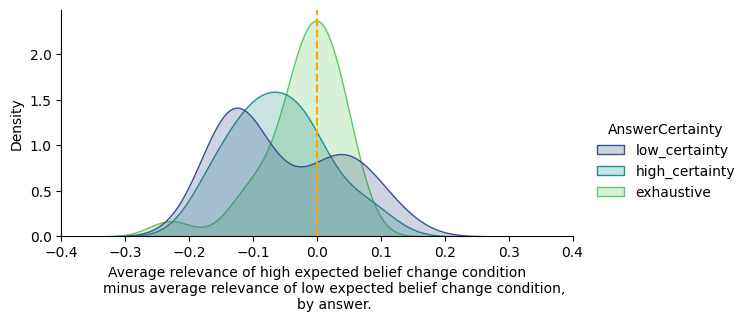

In [32]:
g = sns.displot(data=df_diff,
                hue="AnswerCertainty",
                x="rel_difference",
                hue_order=["low_certainty", "high_certainty", "exhaustive"],
                kind="kde",
                palette="viridis",
                fill=True,
                aspect=2,
                height=3)
g.axes.flatten()[0].set_xlabel(
    """Average relevance of high expected belief change condition
        minus average relevance of low expected belief change condition,
        by answer.""")
g.set(xlim=(-0.4, 0.4))
plt.axvline(x = 0, color = 'orange', linestyle="dashed")

plt.savefig("/content/drive/MyDrive/relevance/figures/impact_of_prior_by_answer_certainty.pdf", bbox_inches="tight")

Plot with no faceting

<ipython-input-33-747524d59801>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.displot(data=df_diff,


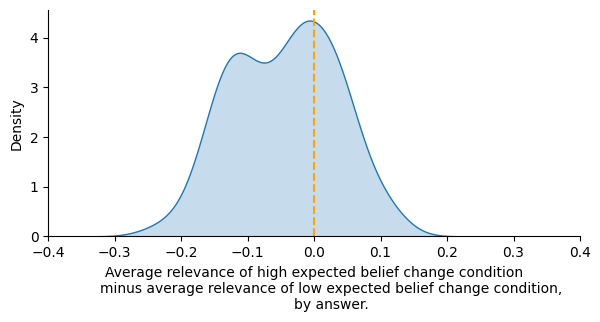

In [33]:
g = sns.displot(data=df_diff,
                # hue="AnswerCertainty",
                x="rel_difference",
                # hue_order=["low_certainty", "high_certainty", "exhaustive"],
                kind="kde",
                palette="viridis",
                fill=True,
                aspect=2,
                height=3)
g.axes.flatten()[0].set_xlabel(
    """Average relevance of high expected belief change condition
        minus average relevance of low expected belief change condition,
        by answer.""")
g.set(xlim=(-0.4, 0.4))
plt.axvline(x = 0, color = 'orange', linestyle="dashed")

plt.savefig("/content/drive/MyDrive/relevance/figures/impact_of_prior.pdf", bbox_inches="tight")

Plotting belief change difference in the same way

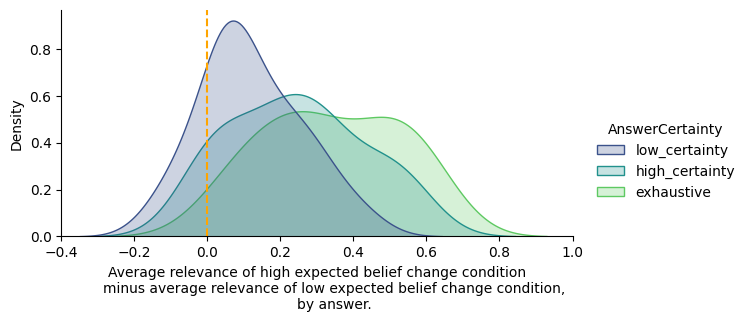

In [31]:
g = sns.displot(data=df_diff,
                hue="AnswerCertainty",
                x="bch_difference",
                hue_order=["low_certainty", "high_certainty", "exhaustive"],
                kind="kde",
                palette="viridis",
                fill=True,
                aspect=2,
                height=3)
g.axes.flatten()[0].set_xlabel(
    """Average relevance of high expected belief change condition
        minus average relevance of low expected belief change condition,
        by answer.""")
g.set(xlim=(-0.4, 1))
plt.axvline(x = 0, color = 'orange', linestyle="dashed")

plt.savefig("/content/drive/MyDrive/relevance/figures/impact_of_prior_by_answer_certainty.pdf", bbox_inches="tight")

2d KDE

<ipython-input-34-d0c8c4c72024>:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.displot(data=df_diff,


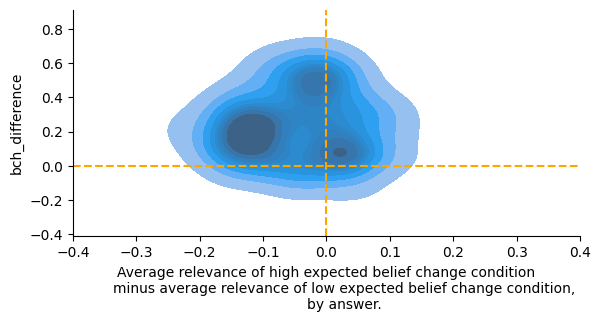

In [34]:
g = sns.displot(data=df_diff,
                # col="AnswerCertainty",
                x="rel_difference",
                y="bch_difference",
                # hue_order=["low_certainty", "high_certainty", "exhaustive"],
                kind="kde",
                palette="viridis",
                fill=True,
                aspect=2,
                height=3)
g.axes.flatten()[0].set_xlabel(
    """Average relevance of high expected belief change condition
        minus average relevance of low expected belief change condition,
        by answer.""")
g.set(xlim=(-0.4, 0.4))
plt.axvline(x = 0, color = 'orange', linestyle="dashed")
plt.axhline(y = 0, color = 'orange', linestyle="dashed")
plt.savefig("/content/drive/MyDrive/relevance/figures/impact_of_prior.pdf", bbox_inches="tight")

# Metrics

## BFU

In [ ]:
df_bfu = df.sort_values(by="bfu_rank_diff")[cols + ["bfu", "bfu_rank_diff"]]
# df_bfu
df_bfu = df_bfu[df_bfu.apply(lambda x: x.bfu > 0 and x.rel < 1, axis=1)]

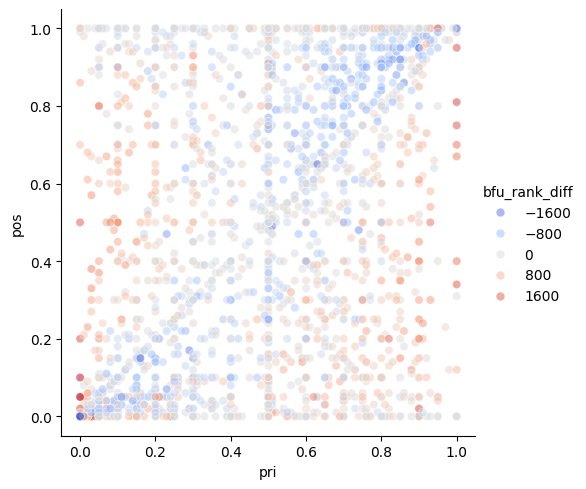

In [ ]:
df_filter = df[df.apply(lambda x: not (x["bch"] == 0 and x["2ord_bch"] == 0 and x["AnswerCertainty"] != "non_answer"), axis=1)]
sns.relplot(data=df_filter, x="pri", y="pos", hue="bfu_rank_diff", palette="coolwarm", alpha=0.5)

In [ ]:
ranks = [

    # 'rel_rank',

    'bch_rank_diff',
    'ech_rank_diff',
    'klu_rank_diff',
    'bfu_rank_diff',

    # '2ord_bch_rank_diff',
    'beta_ech_rank_diff',
    'beta_klu_rank_diff',
    'beta_bfu_rank_diff',
    'beta_bch_rank_diff',
]

other_cols = [

    'pri',
    'pos',
    'rel',
    'conf_pos',
    'conf_pri',
]


df_plot = df_filter[ranks + other_cols].set_index(other_cols).stack().reset_index().rename({"level_5": "rank_type", 0: "rank"}, axis=1)

def extract_metric(name):
    if "ech" in name:
        return "Entropy Change"
    elif "klu" in name:
        return "KL Utility"
    elif "bch" in name:
        return "Belief Change"
    elif "bfu" in name:
        return "Bayes Factor Utility"

def extract_order(name):
    if "beta" in name:
        return "Second Order"
    else:
        return "First Order"

df_plot["metric"] = df_plot["rank_type"].apply(extract_metric)
df_plot["order"] = df_plot["rank_type"].apply(extract_order)
df_plot

,pri,pos,rel,conf_pos,conf_pri,rank_type,rank,metric,order
0,0.70,0.7,0.04,4,4,bch_rank_diff,-16.0,Belief Change,First Order
1,0.70,0.7,0.04,4,4,ech_rank_diff,1.5,Entropy Change,First Order
2,0.70,0.7,0.04,4,4,klu_rank_diff,-16.0,KL Utility,First Order
3,0.70,0.7,0.04,4,4,bfu_rank_diff,119.0,Bayes Factor Utility,First Order
4,0.70,0.7,0.04,4,4,beta_ech_rank_diff,-56.5,Entropy Change,Second Order
...,...,...,...,...,...,...,...,...,...
18075,0.69,0.0,0.86,7,7,bfu_rank_diff,734.0,Bayes Factor Utility,First Order
18076,0.69,0.0,0.86,7,7,beta_ech_rank_diff,670.0,Entropy Change,Second Order
18077,0.69,0.0,0.86,7,7,beta_klu_rank_diff,577.0,KL Utility,Second Order
18078,0.69,0.0,0.86,7,7,beta_bfu_rank_diff,891.0,Bayes Factor Utility,Second Order


Plotting just the relevance score

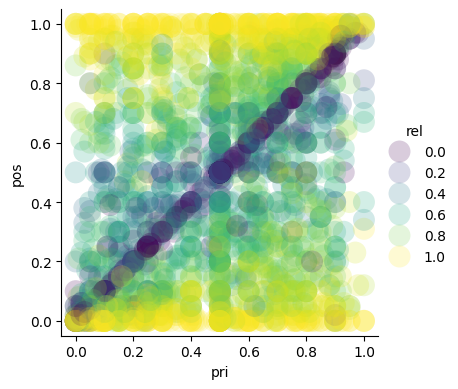

In [ ]:
g = sns.relplot(data=df,
                x="pri",
                y="pos",
                hue="rel",
                palette="viridis",
                alpha=0.2,
                s=250,
                height=4,
                edgecolor='none'
            )

# # Rotate the row titles (y-axis labels)
# for ax, row in zip(g.axes[:,0], df_plot["order"].unique()):
#     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center', rotation=90)
#     ax.set_ylabel("Posterior Probability")

# # Add column titles at the top and remove others
# for ax, col in zip(g.axes[0], df_plot["metric"].unique()):
#     ax.set_title(col)
# for ax in g.axes[1]:
#     ax.set_title("")
#     ax.set_xlabel("Prior Probability")

# g._legend.set_title('Δ Rank')

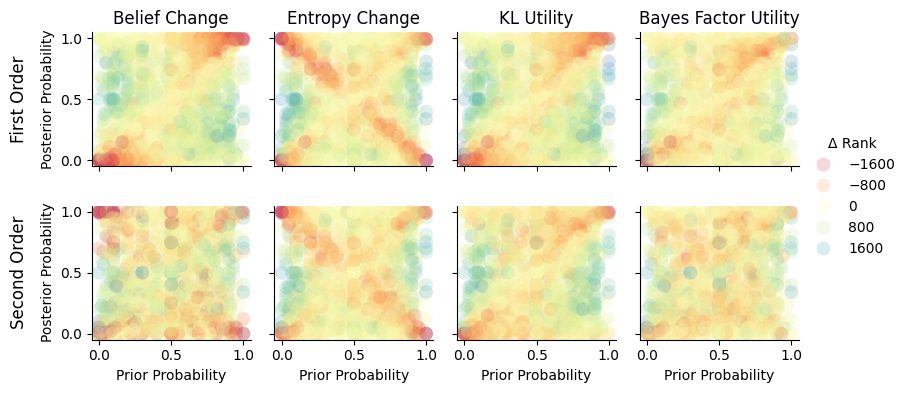

In [ ]:
def plot_rank_diffs(data_subset):
    g = sns.relplot(data=data_subset,
                    x="pri",
                    y="pos",
                    hue="rank",
                    col="metric",
                    row="order",
                    palette="Spectral",
                    alpha=0.2,
                    s=100,
                    height=2,
                    edgecolor='none'
                )

    # Rotate the row titles (y-axis labels)
    for ax, row in zip(g.axes[:,0], df_plot["order"].unique()):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center', rotation=90)
        ax.set_ylabel("Posterior Probability")

    # Add column titles at the top and remove others
    for ax, col in zip(g.axes[0], df_plot["metric"].unique()):
        ax.set_title(col)
    for ax in g.axes[1]:
        ax.set_title("")
        ax.set_xlabel("Prior Probability")

    g._legend.set_title('Δ Rank')

plt.savefig("/content/drive/MyDrive/relevance/figures/rank_difference.pdf")

Let's redo this plot but only focus on the corners

<ipython-input-12-d882fd4de34d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_extreme["pri"] = df_extreme.pri.apply(lambda x: r * x if x < p else 1 - (r * (1-x)))
<ipython-input-12-d882fd4de34d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_extreme["pos"] = df_extreme.pos.apply(lambda x: r * x if x < p else 1 - (r * (1-x)))


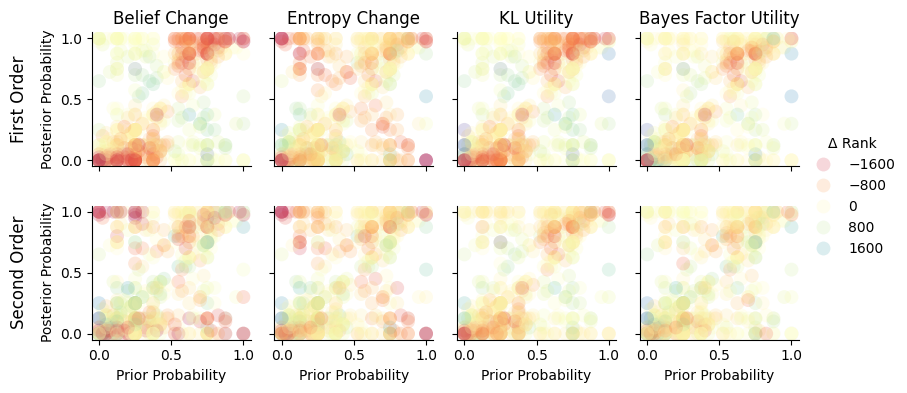

In [ ]:
p = 0.2
q = 1-p
r = 0.5 / p
df_extreme = df_plot[df_plot.apply(lambda x:
                                    (x.pri < p and x.pos < p) or
                                    (x.pri < p and x.pos > q) or
                                    (x.pri > q and x.pos < p) or
                                    (x.pri > q and x.pos > q),
                                axis=1)]

df_extreme["pri"] = df_extreme.pri.apply(lambda x: r * x if x < p else 1 - (r * (1-x)))
df_extreme["pos"] = df_extreme.pos.apply(lambda x: r * x if x < p else 1 - (r * (1-x)))
plot_rank_diffs(df_extreme)

Let's pull out examples where there was small first-order belief change, but high second-order belief change

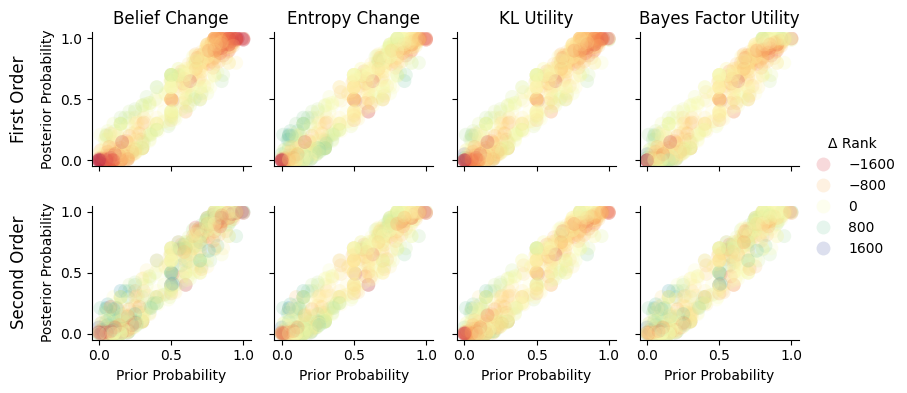

In [ ]:
df_small_bc = df_plot[df_plot.apply(lambda x:
                                    abs(x.pos - x.pri) < 0.2 and x.rel > 0.5,
                                    axis=1
                                    )]
g = sns.relplot(data=df_small_bc,
                x="pri",
                y="pos",
                hue="rank",
                col="metric",
                row="order",
                palette="Spectral",
                alpha=0.2,
                s=100,
                height=2,
                edgecolor='none'
            )

# Rotate the row titles (y-axis labels)
for ax, row in zip(g.axes[:,0], df_plot["order"].unique()):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)
    ax.set_ylabel("Posterior Probability")

# Add column titles at the top and remove others
for ax, col in zip(g.axes[0], df_plot["metric"].unique()):
    ax.set_title(col)
for ax in g.axes[1]:
    ax.set_title("")
    ax.set_xlabel("Prior Probability")

g._legend.set_title('Δ Rank')

In [ ]:
# df_small_bc = df_plot[df_plot.apply(lambda x:
#                                     abs(x.pos - x.pri) < 0.1 and x.rel > 0.5 and x.,
#                                     axis=1
#                                     )]
# df_small_bc
print(df.columns)
df[df.apply(lambda x:
            abs(x.pos - x.pri) < 0.1 and
            x.rel > 0.5 and
            x.klu_rank_diff < -500,
            axis=1
            )][cols + ["klu_rank_diff", "beta_klu_rank_diff", "bfu_rank_diff", "beta_bfu_rank_diff"]]

Index(['submission_id', 'StimID', 'AnswerCertainty', 'AnswerPolarity',
       'ContextType', 'pos', 'pri', 'rel', 'bch', 'ech', 'klu', 'bfu',
       'conf_pos', 'conf_pri', '2ord_bch', 'beta_ech', 'beta_klu', 'beta_bfu',
       'beta_bch', 'RowID', 'GroupID', 'pos_rank', 'pri_rank', 'rel_rank',
       'bch_rank', 'ech_rank', 'klu_rank', 'bfu_rank', 'conf_pos_rank',
       'conf_pri_rank', '2ord_bch_rank', 'beta_ech_rank', 'beta_klu_rank',
       'beta_bfu_rank', 'beta_bch_rank', 'pos_rank_diff', 'pri_rank_diff',
       'rel_rank_diff', 'bch_rank_diff', 'ech_rank_diff', 'klu_rank_diff',
       'bfu_rank_diff', 'conf_pos_rank_diff', 'conf_pri_rank_diff',
       '2ord_bch_rank_diff', 'beta_ech_rank_diff', 'beta_klu_rank_diff',
       'beta_bfu_rank_diff', 'beta_bch_rank_diff', 'pos_mean', 'pos_rank_mean',
       'pos_rank_diff_mean', 'pri_mean', 'pri_rank_mean', 'pri_rank_diff_mean',
       'rel_mean', 'rel_rank_mean', 'rel_rank_diff_mean', 'bch_mean',
       'bch_rank_mean', 'bch_rank_di

,RowID,AnswerCertainty,ContextType,Answer,Context,YourQuestionIntro,YourQuestion,pri,pos,conf_pri,conf_pos,rel,rel_rank,bfu_rank_diff,beta_bfu_rank_diff,klu_rank_diff,beta_klu_rank_diff,bfu_rank_diff,beta_bfu_rank_diff
14,3low_certaintypositivenegative5869,low_certainty,negative,He lives in the suburbs.,"Joe is the new guy at work, and he's pretty cu...",You ask your coworker Laura:,Is Joe married?,0.60,0.60,5,6,0.60,713.0,-570.0,544.0,-556.0,-459.0,-570.0,544.0
28,5exhaustivepositivenegative6041,exhaustive,negative,The whole family is inside the house.,You're a burglar on your way to meet your acco...,You text your accomplice Chris:,Is there anyone inside the house?,0.01,0.00,7,6,1.00,2134.0,27.0,-275.0,-1627.0,-1503.0,27.0,-275.0
32,6high_certaintypositiveneutral5840,high_certainty,neutral,The cake box is still on the counter in the ki...,It's afternoon at the office and you're ready ...,You ask your coworker Meaghan:,Is there any cake left?,0.25,0.35,7,7,0.80,1269.0,-689.5,517.0,-613.0,-212.0,-689.5,517.0
58,8high_certaintynegativepositive5834,high_certainty,positive,Tony knows that Ethan has too many cookbooks.,Tony got Ethan a book-shaped birthday gift. Th...,You ask your friend Claire:,Did Tony get Ethan a cookbook for his birthday?,0.90,0.95,7,7,1.00,2134.0,-1392.0,-402.5,-1574.0,-1129.0,-1392.0,-402.5
73,9low_certaintynegativenegative6066,low_certainty,negative,"It's a small town, and most restaurants are cl...","After a rowdy Sunday night, you wake up on Mon...",You ask your roommate Buster:,Is the pizza place open today?,0.10,0.05,5,6,0.80,1269.0,-527.0,-12.0,-709.0,-612.5,-527.0,-12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331,1high_certaintypositivepositive5930,high_certainty,positive,There's a wedding canopy set up on the beach.,It's the day of Kim and Sam's wedding. The wed...,You ask your friend Clara:,Will they have the ceremony outdoors?,0.85,0.95,6,4,0.90,1541.0,-500.5,-25.0,-704.0,-397.0,-500.5,-25.0
2333,1high_certaintypositivepositive6009,high_certainty,positive,There's a wedding canopy set up on the beach.,It's the day of Kim and Sam's wedding. The wed...,You ask your friend Clara:,Will they have the ceremony outdoors?,0.95,0.99,6,7,0.95,1719.5,-427.0,139.5,-1067.5,-704.0,-427.0,139.5
2335,6exhaustivenegativenegative5927,exhaustive,negative,The cake is finished.,It's afternoon at the office and you're ready ...,You ask your coworker Meaghan:,Is there any cake left?,0.05,0.00,3,7,1.00,2134.0,27.0,19.5,-1283.0,-1179.0,27.0,19.5
2336,6exhaustivenegativenegative5932,exhaustive,negative,The cake is finished.,It's afternoon at the office and you're ready ...,You ask your coworker Meaghan:,Is there any cake left?,0.09,0.00,4,7,1.00,2134.0,27.0,-11.5,-1095.0,-842.5,27.0,-11.5


Let's try to plot for one metric, separating data points by change in confidence

In [ ]:
def conf_coarse(conf):
    return {
        1: "1-2",
        2: "1-2",
        3: "3-4",
        4: "3-4",
        5: "5",
        6: "6",
        7: "7"
    }[conf]

df_plot["conf_pri_coarse"] = df_plot["conf_pri"].apply(conf_coarse)
df_plot["conf_pos_coarse"] = df_plot["conf_pos"].apply(conf_coarse)

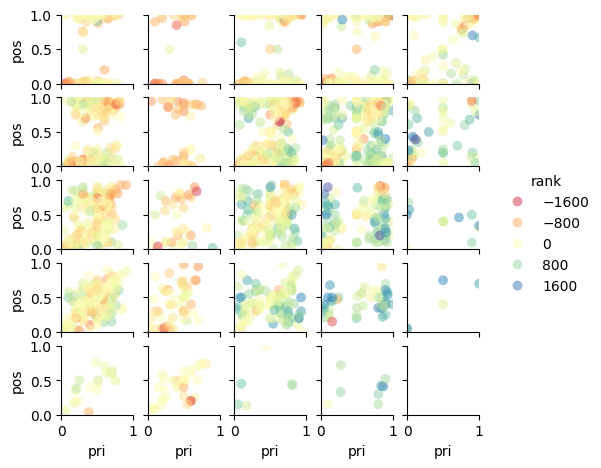

In [ ]:
df_beta_klu = df_plot[df_plot["rank_type"]=="beta_klu_rank_diff"]
g = sns.relplot(data=df_beta_klu,
                x="pri",
                y="pos",
                hue="rank",
                col="conf_pri_coarse",
                row="conf_pos_coarse",
                row_order=["7", "6", "5", "3-4", "1-2"],
                palette="Spectral",
                alpha=0.5,
                s=50,
                edgecolor='none',
                height=1,
                aspect=1
                )
g.set_titles("")
g.set(ylim=(0, 1), xlim=(0, 1))
plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1, wspace=0.2, hspace=0.2)
